In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

# Load the data
df = pd.read_csv('hotel_booking.csv')

# Initial inspection
print(df.info())
print(df.head())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [27]:
df.columns = df.columns.str.strip()
print("Cleaned column names:")
print(df.columns.tolist())


Cleaned column names:
['BookingID', 'numberofadults', 'numberofchildren', 'numberofweekendnights', 'numberofweeknights', 'typeofmeal', 'carparkingspace', 'roomtype', 'leadtime', 'marketsegmenttype', 'repeated', 'P-C', 'P-not-C', 'averageprice', 'specialrequests', 'dateofreservation', 'bookingstatus']


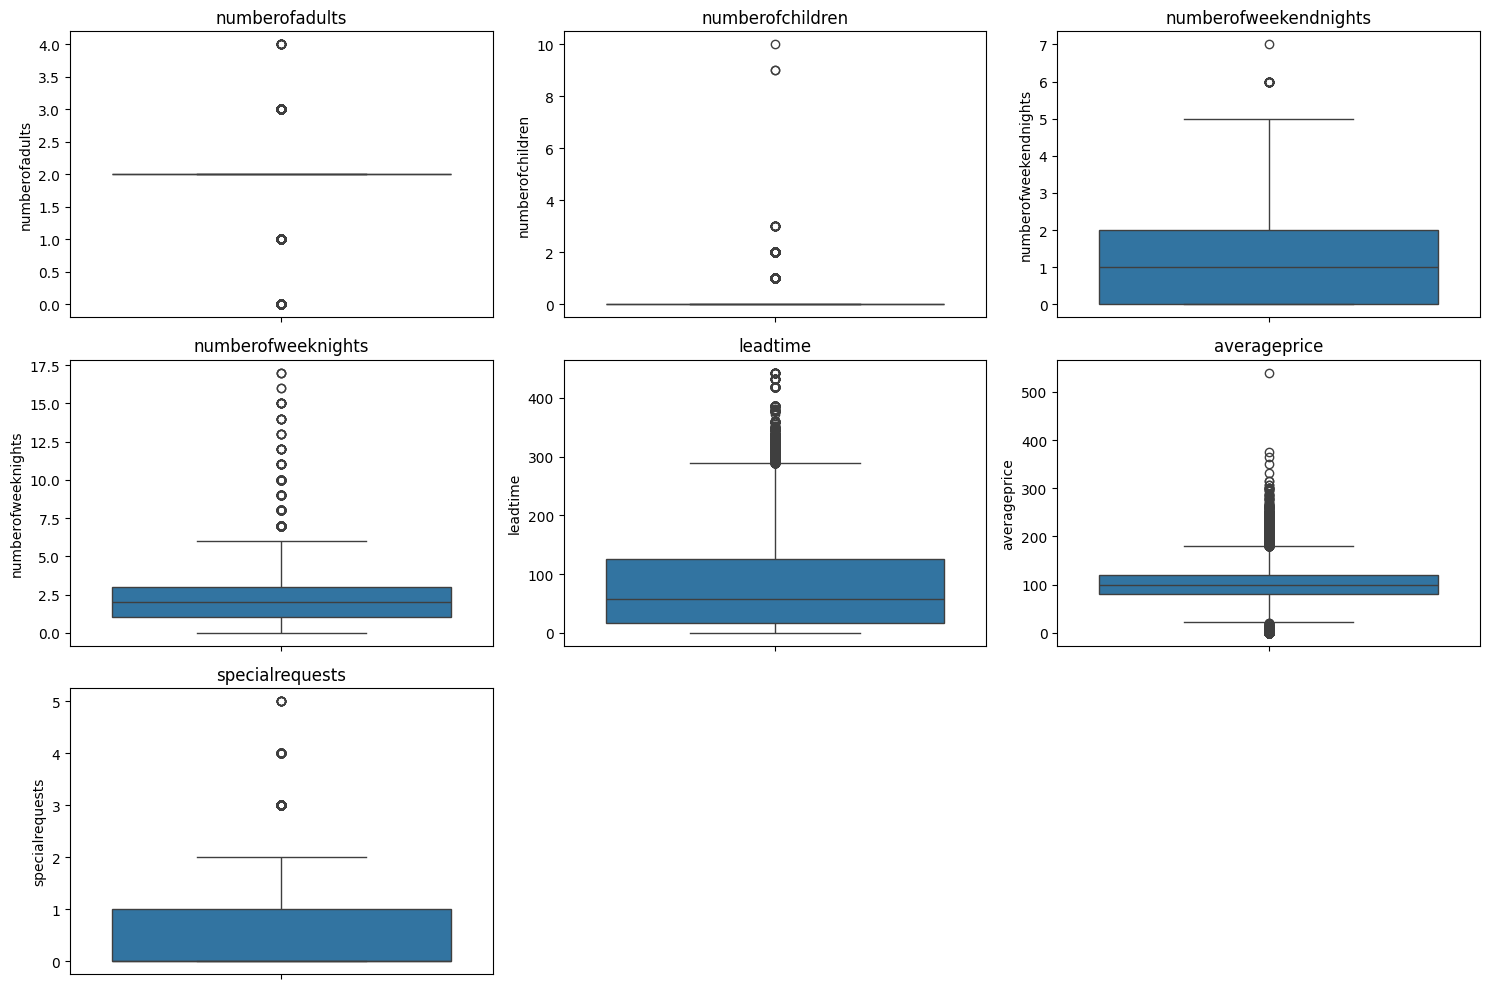

In [30]:

# Select numerical columns
num_cols = ['numberofadults', 'numberofchildren', 'numberofweekendnights',
            'numberofweeknights', 'leadtime', 'averageprice', 'specialrequests']

# Visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(col)
plt.tight_layout()
plt.show()

# Handle outliers using IQR
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [36]:
# Create new features
df['total_guests'] = df['numberofadults'] + df['numberofchildren']
df['total_nights'] = df['numberofweekendnights'] + df['numberofweeknights']
df['pricepernight'] = df['averageprice'] / df['total_nights'].replace(0, 1)  # avoid division by zero

# Extract month and year from reservation date
df['reservation_month'] = df['dateofreservation'].dt.month
df['reservation_year'] = df['dateofreservation'].dt.year

In [34]:
# Encode categorical variables
cat_cols = ['typeofmeal', 'roomtype', 'marketsegmenttype', 'repeated']

# Label encoding for binary or ordinal categories
label_encoders = {}
for col in ['repeated', 'bookingstatus']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-hot encoding for nominal categories
df = pd.get_dummies(df, columns=['typeofmeal', 'roomtype', 'marketsegmenttype'], drop_first=True)

In [37]:
# Define features and target
X = df.drop(['BookingID', 'dateofreservation', 'bookingstatus', 'P-C', 'P-not-C'], axis=1)
y = df['bookingstatus']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['leadtime', 'averageprice', 'specialrequests', 'total_guests', 'total_nights', 'pricepernight']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Accuracy: 0.8899310344827587

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3565
           1       0.90      0.94      0.92      7310

    accuracy                           0.89     10875
   macro avg       0.88      0.86      0.87     10875
weighted avg       0.89      0.89      0.89     10875



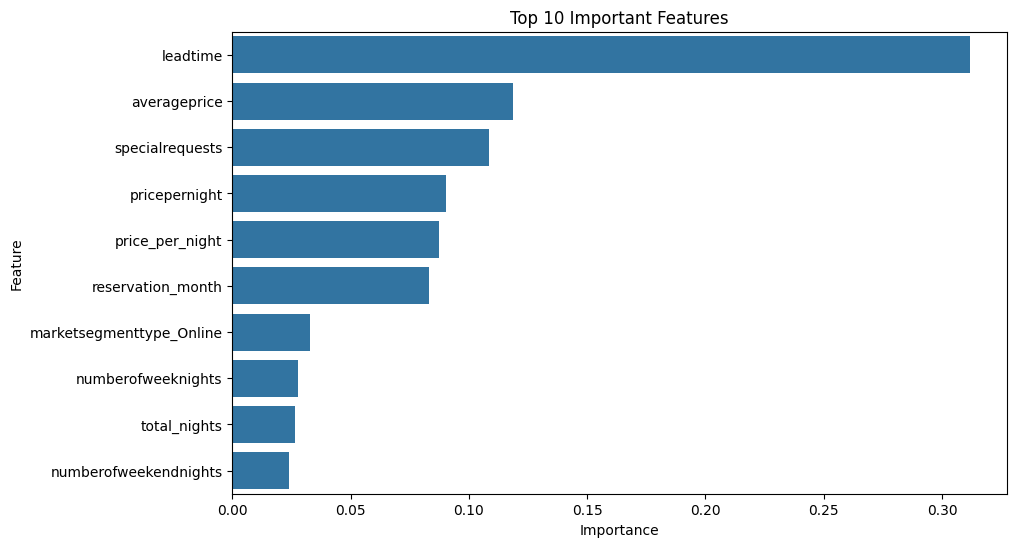

In [38]:
# Initialize and train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.show()